This tutorial is based on the paper *Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing* by **Lénaïc Chizat (2024)**, which introduces and analyzes the theoretical foundations and practical benefits of annealing strategies in entropy-regularized optimal transport.

### Introduction: Annealed Sinkhorn for Optimal Transport

This tutorial investigates the **Annealed Sinkhorn algorithm** for solving optimal transport (OT) problems. While the classical **Sinkhorn algorithm** solves an entropy-regularized OT problem efficiently, its performance depends critically on the inverse temperature parameter $\beta$:

- Small $\beta$: fast convergence, but large entropic bias  
- Large $\beta$: closer to the unregularized OT solution, but slower convergence

To improve this trade-off, practitioners use **Annealed Sinkhorn**, where $\beta_t$ increases over iterations. This results in a sequence of relaxed problems that gradually approach the true OT solution.

This notebook aims to:

1. **Introduce** the theoretical foundations of Annealed Sinkhorn and its motivations.
2. **Implement** both the standard version (via OTT-JAX epsilon schedulers) and a custom variant with polynomial schedules like $\beta_t = \sqrt{1 + t}$.
3. **Compare** convergence behaviors across different schedules and costs.
---

### Core Algorithms from the Paper

Before introducing the experimental setups, we summarize the three core algorithms used in the *Annealed Sinkhorn* paper. These are the building blocks of our analysis.

#### Algorithm 1: Annealed Sinkhorn
This algorithm solves a sequence of entropic OT problems with increasing inverse temperature $(\beta_t)$. At each iteration, it performs one step of Sinkhorn with an updated kernel.

**Annealed Sinkhorn (simplified):**

1. Initialize: $b_0 = \mathbf{1}$, $K_0 = e^{-\beta_0 C}$
2. For $t = 1, 2, \dots$
   - $a_t = p \oslash (K_{t-1} b_{t-1})$  
   - $K_t = e^{-\beta_t C}$  
   - $b_t = q \oslash (K_t^\top a_t)$  
   - $\pi_t = \mathrm{diag}(a_t) K_t \mathrm{diag}(b_t)$

Here, the marginals are progressively adjusted to satisfy the constraints while refining the regularization strength via $\beta_t$.

#### Algorithm 2: Projection onto Transport Plans

To fairly evaluate the suboptimality of $\pi_t$ (which might not exactly satisfy the marginal constraints), the paper applies a lightweight projection onto the set of feasible transport plans $\Gamma(p, q)$.

**Projection Algorithm (Altschuler et al. 2017):**

Given a matrix $\pi$:

1. $\pi' = \mathrm{diag}(\min\{1, p \oslash (\pi \mathbf{1})\}) \cdot \pi$
2. $\pi'' = \pi' \cdot \mathrm{diag}(\min\{1, q \oslash (\pi'^\top \mathbf{1})\})$
3. Let $\Delta p = p - \pi'' \mathbf{1}$, $\Delta q = q - \pi''^\top \mathbf{1}$
4. Return: $\bar{\pi} = \pi'' + \frac{\Delta p \Delta q^\top}{\|\Delta p\|_1}$

This projection is used to fairly compare plans across algorithms.

#### Algorithm 3: Debiased Annealed Sinkhorn

To reduce the "relaxation error" caused by fast growth of $\beta_t$, the paper proposes a **Debiased** version of Annealed Sinkhorn. It modifies the scaling of $a_t$ to absorb the discrepancy between marginals.

**Debiased Annealed Sinkhorn:**

1. Initialize: $b_0 = \mathbf{1}$, $K_0 = e^{-\beta_0 C}$
2. For $t = 1, 2, \dots$
   - $a_t = \left( a_{t-1}^{1 - \frac{\beta_{t-2}}{\beta_{t-1}}} \odot p \right) \oslash (K_{t-1} b_{t-1})$
   - $K_t = e^{-\beta_t C}$
   - $b_t = q \oslash (K_t^\top a_t)$
   - $\pi_t = \mathrm{diag}(a_t) K_t \mathrm{diag}(b_t)$

This modification improves convergence by canceling out first-order errors in the marginal relaxation.

These three algorithms form the backbone of the empirical and theoretical results we aim to reproduce.

---

### Annealed Sinkhorn using OTT’s epsilon_scheduler
In this first experiment, we mimic Annealed Sinkhorn using the epsilon_scheduler class provided in the OTT-JAX library. This approach leverages an exponentially decaying $\varepsilon_t = 1/\beta_t$, which automatically updates the regularization strength during the Sinkhorn iterations.

However, note that Epsilon only supports geometric decay of the regularization parameter: the schedule follows $\varepsilon_t = \texttt{target} \times \texttt{init} \times \texttt{decay}^t$. This restricts us to exponential annealing of $\beta_t = 1 / \varepsilon_t$, and prevents the use of theoretically motivated schedules such as $\beta_t = \sqrt{1 + t}$ proposed in the paper.

We now set up the geometrical point cloud example used throughout this tutorial:

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import ott
from ott.geometry import pointcloud
from ott.solvers.linear import solve
from ott.geometry import pointcloud, costs, epsilon_scheduler
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import time


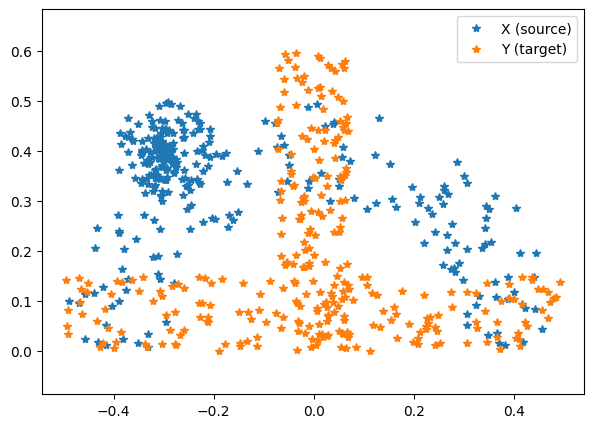

OT cost: 0.07802588


In [2]:
# Seed and keys
key = jax.random.PRNGKey(1)
key, *subkeys = jax.random.split(key, 10)

# First cloud X = X1 ∪ X2
m = 150
ang1 = jax.random.uniform(subkeys[0], (m,), minval=0, maxval=jnp.pi)
rad1 = jax.random.uniform(subkeys[1], (m,), minval=0.3, maxval=0.5)
X1 = jnp.stack([rad1 * jnp.cos(ang1), rad1 * jnp.sin(ang1)], axis=1)

ang2 = jax.random.uniform(subkeys[2], (m,), minval=0, maxval=2*jnp.pi)
rad2 = jax.random.uniform(subkeys[3], (m,), minval=0.0, maxval=0.1)
X2 = jnp.stack([
    rad2 * jnp.cos(ang2) - 0.3,
    rad2 * jnp.sin(ang2) + 0.4
], axis=1)

X = jnp.concatenate([X1, X2], axis=0)

# Second cloud Y = Y1 ∪ Y2
n = 150
Y1 = jnp.stack([
    jax.random.uniform(subkeys[4], (n,), minval=-0.5, maxval=0.5),
    jax.random.uniform(subkeys[5], (n,), minval=0.0, maxval=0.15)
], axis=1)

Y2 = jnp.stack([
    (jax.random.uniform(subkeys[6], (n,), minval=-0.5, maxval=0.5)) * 0.15,
    jax.random.uniform(subkeys[7], (n,), minval=0.0, maxval=0.6)
], axis=1)

Y = jnp.concatenate([Y1, Y2], axis=0)

# Visualisation
plt.figure(figsize=(7, 5))
plt.plot(X[:, 0], X[:, 1], "*", label="X (source)")
plt.plot(Y[:, 0], Y[:, 1], "*", label="Y (target)")
plt.axis("equal")
plt.legend()
plt.show()

# Histograms (uniform)
p = jnp.ones(X.shape[0]) / X.shape[0]
q = jnp.ones(Y.shape[0]) / Y.shape[0]

# Define geometry and solve OT problem (EMD)
geom = pointcloud.PointCloud(X, Y)  # l2 cost by default
out = ott.solvers.linear.solve(geom, a=p, b=q)

# Extract plan and cost
plan_opt = out.matrix  # γ ∈ R^{300×300}
OT_cost = jnp.sum(plan_opt * geom.cost_matrix) 
c = geom.cost_matrix 
print("OT cost:", OT_cost)

In [3]:

def run_sinkhorn_variant_1(x, y, p, q, epsilon_fn, name="", threshold=1e-3):
    epsilon = epsilon_fn()
    geom = pointcloud.PointCloud(
        x=x, y=y,
        cost_fn=costs.Euclidean(),
        epsilon=epsilon,
        scale_cost="mean"
    )
    prob = linear_problem.LinearProblem(geom, a=p, b=q)

    solver = sinkhorn.Sinkhorn(threshold=threshold)

    start = time.time()
    sol = solver(prob)
    end = time.time()

    n_iter = int(jnp.sum(sol.errors > -1))
    final_err = float(sol.errors[(sol.errors > -1)][-1])
    runtime = end - start
    transport_cost = float(jnp.sum(sol.matrix * geom.cost_matrix))

    return {
        "name": name,
        "iterations": n_iter,
        "error": final_err,
        "runtime": runtime,
        "transport_cost": transport_cost,
        "matrix": sol.matrix,
        "cost_matrix": geom.cost_matrix
    }

def compare_convergence_speed_1(x, y, p, q, threshold=1e-6):
    variants = [
        {"name": "Fixed ε = 1e-1", "epsilon_fn": lambda: 1e-1},
        {"name": "Fixed ε = 5e-2", "epsilon_fn": lambda: 5e-2},
        
        {"name": "Sched target=1e-2 init=5 decay=0.95", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-2, init=5.0, decay=0.95)},
        {"name": "Sched target=1e-2 init=3 decay=0.97", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-2, init=3.0, decay=0.97)},
        {"name": "Sched target=5e-3 init=3 decay=0.97", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=5e-3, init=3.0, decay=0.97)},
        {"name": "Sched target=1e-1 init=2 decay=0.9", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-3, init=10.0, decay=0.98)},
        {"name": "Sched target=1e-3 init=10 decay=0.98", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-3, init=10.0, decay=0.98)},
    ]

    print(f"=== Convergence summary (threshold = {threshold}) ===")

    results = []
    for v in variants:
        res = run_sinkhorn_variant_1(x, y, p, q, epsilon_fn=v["epsilon_fn"], name=v["name"], threshold=threshold)
        results.append(res)
        print(f"{res['name']:45s} → {res['iterations']:4d} iters | "
              f"error: {res['error']:.2e} | "
              f"time: {res['runtime']:.3f} s | "
              f"transport cost: {res['transport_cost']:.5f}")

    # Plot iterations
    labels = [r["name"] for r in results]
    iters = [r["iterations"] for r in results]
    times = [r["runtime"] for r in results]

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].barh(labels, iters, color="skyblue")
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_title("Convergence iterations per method")
    axs[0].grid(True, axis="x", linestyle="--", alpha=0.5)

    axs[1].barh(labels, times, color="orange")
    axs[1].set_xlabel("Runtime (s)")
    axs[1].set_title("Runtime per method")
    axs[1].grid(True, axis="x", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()



def project_plan(pi, p, q):
    pi_prime = pi * jnp.minimum(1.0, p[:, None] / jnp.sum(pi, axis=1, keepdims=True))
    pi_pprime = pi_prime * jnp.minimum(1.0, q[None, :] / jnp.sum(pi_prime, axis=0, keepdims=True))
    delta_p = p - jnp.sum(pi_pprime, axis=1)
    delta_q = q - jnp.sum(pi_pprime, axis=0)
    correction = jnp.outer(delta_p, delta_q) / jnp.linalg.norm(delta_p, ord=1)
    return pi_pprime + correction

def compute_emd_cost(x, y, p, q):
    geom = pointcloud.PointCloud(x, y, scale_cost="mean")  # by default: cost = ||x - y||², no scaling
    out = solve(geom, a=p, b=q)
    plan_opt = out.matrix
    ot_cost = float(jnp.sum(plan_opt * geom.cost_matrix))
    return ot_cost


def compare_suboptimality(x, y, p, q, threshold=1e-6):
    variants = [
        {"name": "Fixed ε = 1e-1", "epsilon_fn": lambda: 1e-1},
        {"name": "Fixed ε = 5e-2", "epsilon_fn": lambda: 5e-2},
        
        {"name": "Sched target=1e-2 init=5 decay=0.95", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-2, init=5.0, decay=0.95)},
        {"name": "Sched target=1e-2 init=3 decay=0.97", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-2, init=3.0, decay=0.97)},
        {"name": "Sched target=5e-3 init=3 decay=0.97", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=5e-3, init=3.0, decay=0.97)},
        {"name": "Sched target=1e-1 init=2 decay=0.9", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-1, init=2.0, decay=0.9)},
        {"name": "Sched target=1e-3 init=10 decay=0.98", "epsilon_fn": lambda: epsilon_scheduler.Epsilon(target=1e-3, init=10.0, decay=0.98)},
    ]

    emd_cost = compute_emd_cost(x, y, p, q)
    print(f"Optimal OT cost (EMD) = {emd_cost:.5f}")

    subopts = []
    for v in variants:
        res = run_sinkhorn_variant_1(x, y, p, q, epsilon_fn=v["epsilon_fn"], name=v["name"], threshold=threshold)
        pi_proj = project_plan(res["matrix"], p, q)
        cost_proj = float(jnp.sum(pi_proj * res["cost_matrix"]))
        subopt = cost_proj - emd_cost
        subopts.append((v["name"], subopt))

    print(f"\n=== Suboptimality (projected plans, threshold={threshold}) ===")
    for name, sub in subopts:
        print(f"{name:45s} → subopt: {sub:.5f}")

    # Plot
    labels = [s[0] for s in subopts]
    values = [s[1] for s in subopts]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, values, color="coral")
    plt.axvline(0, color="gray", linestyle="--")
    plt.xlabel("Projected suboptimality:  ⟨C, π_proj⟩ - OT(p, q)")
    plt.title("Suboptimality vs EMD for various Sinkhorn schedulers")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


=== Convergence summary (threshold = 1e-06) ===
Fixed ε = 1e-1                                →    9 iters | error: 8.55e-07 | time: 0.263 s | transport cost: 0.64898
Fixed ε = 5e-2                                →   22 iters | error: 9.56e-07 | time: 0.200 s | transport cost: 0.61807
Sched target=1e-2 init=5 decay=0.95           →  134 iters | error: 9.95e-07 | time: 0.600 s | transport cost: 0.59408
Sched target=1e-2 init=3 decay=0.97           →  138 iters | error: 9.10e-07 | time: 0.598 s | transport cost: 0.59408
Sched target=5e-3 init=3 decay=0.97           →  200 iters | error: 3.26e-05 | time: 0.816 s | transport cost: 0.59152
Sched target=1e-1 init=2 decay=0.9            →  200 iters | error: 2.03e-02 | time: 0.816 s | transport cost: 0.58531
Sched target=1e-3 init=10 decay=0.98          →  200 iters | error: 2.03e-02 | time: 0.833 s | transport cost: 0.58531


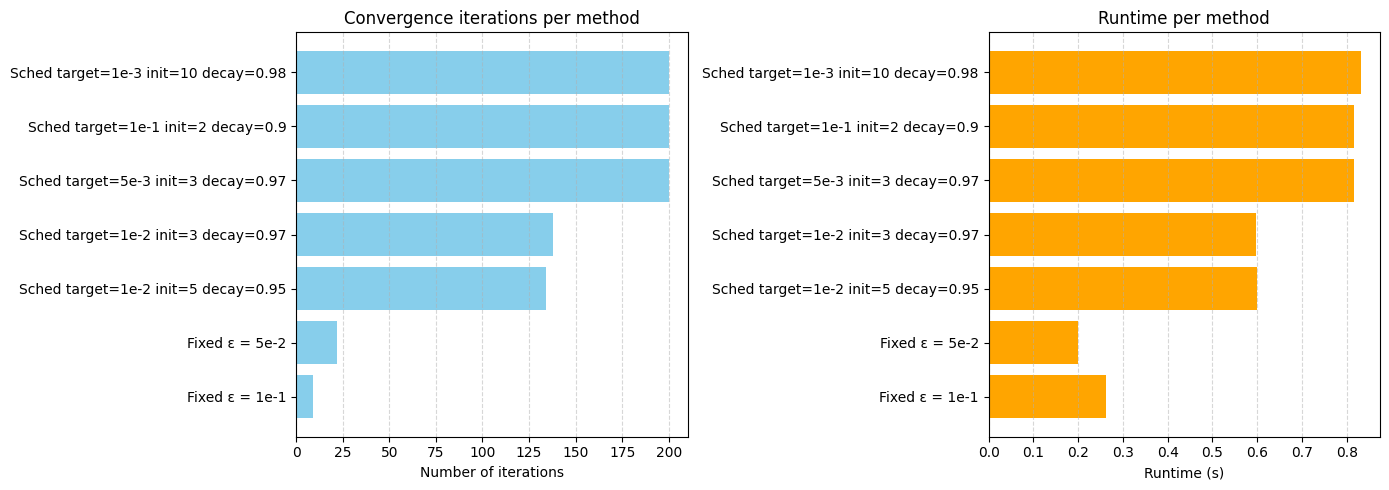

Optimal OT cost (EMD) = 0.39600

=== Suboptimality (projected plans, threshold=1e-06) ===
Fixed ε = 1e-1                                → subopt: 0.25298
Fixed ε = 5e-2                                → subopt: 0.22208
Sched target=1e-2 init=5 decay=0.95           → subopt: 0.19809
Sched target=1e-2 init=3 decay=0.97           → subopt: 0.19809
Sched target=5e-3 init=3 decay=0.97           → subopt: 0.19554
Sched target=1e-1 init=2 decay=0.9            → subopt: 0.25298
Sched target=1e-3 init=10 decay=0.98          → subopt: 0.19962


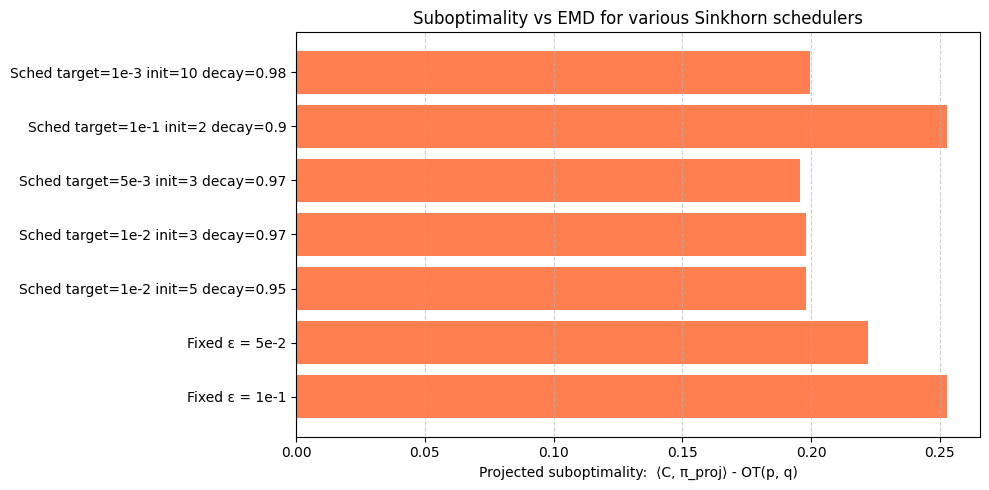

In [4]:
compare_convergence_speed_1(X, Y, p, q, threshold=1e-6)
compare_suboptimality(X, Y, p, q, threshold=1e-6)

###  Summary

Sinkhorn methods with schedulers **converge more slowly** than fixed-$\varepsilon$ methods, both in terms of iterations and runtime. However, they can yield **better transport costs** if the regularization is sufficiently low.

In the end, the **suboptimality mostly depends on the scheduler's target** value: once $\varepsilon_t$ stabilizes, the solver behaves like a fixed-$\varepsilon$ method. The schedule (decay/init) mainly influences **how fast** that target is reached.

*Note: all transport costs were computed with normalized costs (scale_cost="mean").*

---


###  Limitations of the Epsilon Scheduler and Sinkhorn Solver in OTT

The built-in `Epsilon` scheduler in OTT produces regularization schedules of the form:

$$
\varepsilon_t = \texttt{target} \times \texttt{init} \times \texttt{decay}^t
\quad \text{or equivalently} \quad
\beta_t = \frac{1}{\varepsilon_t} = \frac{1}{\texttt{target} \cdot \texttt{init}} \cdot \left(\frac{1}{\texttt{decay}}\right)^t
$$

This corresponds to **exponentially growing** $\beta_t$, whereas the paper *Annealed Sinkhorn for Optimal Transport* by Lénaïc Chizat (2024) recommends **slower, polynomial growth rates**, such as $\beta_t = \sqrt{1 + t}$, which are theoretically optimal for certain OT problems.

Additionally, the `Sinkhorn` solver in OTT does not expose intermediate transport plans $\pi_t$, nor does it allow tracking the **projected suboptimality**:

$$
\text{subopt}_t = \langle C, \bar{\pi}_t \rangle - \text{OT}(p, q)
$$

This limits the ability to evaluate how the algorithm progresses toward the unregularized OT solution, especially when comparing different annealing strategies. A custom implementation of Annealed Sinkhorn is required to monitor this quantity.


### Custom Implementation

The implementation of `sinkhorn_track` used throughout this notebook is heavily inspired by the work of Lénaïc Chizat in the paper *Annealed Sinkhorn for Optimal Transport* (2024).

This custom routine reproduces the key features of the **annealing strategy** proposed in the paper, where the regularization parameter $\beta_t$ (inverse of the entropy weight $\varepsilon_t$) is gradually increased over time following a power law schedule:

$$
\beta_t = \beta_0 (1 + t)^\kappa
$$

Such a schedule contrasts with geometric decay used in common Sinkhorn implementations (e.g., in OTT), and is theoretically motivated to improve convergence to the true OT solution.

In addition, the implementation integrates the **Debiased Annealed Sinkhorn** variant introduced in the same paper. This version corrects the systematic bias induced by entropic regularization by incorporating a dynamic correction term in the dual updates. The idea is to counteract the inertia induced by increasing regularization, ensuring that the potentials adapt better over time and leading to improved convergence rates — especially when $\kappa$ is close to the theoretically optimal $2/3$.

This setup allows us to:
- Simulate both classical and annealed Sinkhorn variants
- Analyze the impact of $\kappa$ on convergence
- Visualize the projected suboptimality relative to the EMD solution


In this experiment, we generate two random discrete distributions $p$ and $q$ of size 100, normalized to sum to 1. The cost matrix $C \in \mathbb{R}^{100 \times 100}$ is built from Gaussian noise and rescaled to lie in $[0, 1]$.

In [5]:
from ott.geometry import geometry
# Set seed
key = jax.random.PRNGKey(1)
key, k1, k2, k3 = jax.random.split(key, 4)

# Generate two random histograms
m, n = 100, 100
p = jax.random.uniform(k1, (m,))
q = jax.random.uniform(k2, (n,))
p = p / jnp.sum(p)
q = q / jnp.sum(q)

# Generate a random cost matrix
c_raw = jax.random.normal(k3, (m, n))
c = (c_raw - jnp.min(c_raw)) / (jnp.max(c_raw) - jnp.min(c_raw))

# Define geometry with custom cost matrix
geom = geometry.Geometry(cost_matrix=c)

# Solve optimal transport (EMD)
out = solve(geom, a=p, b=q)  # epsilon=0.0 par défaut = EMD

# Extract optimal plan and cost
plan_opt = out.matrix
OT_cost = jnp.sum(plan_opt * c)

In [ ]:
def sinkhorn_track(p, q, c, niter=100, OT_cost=0.0, kappa=0.0, beta0=1.0, debiased=True, iter_stop=None, plateau_length=1):
    m, n = p.shape[0], q.shape[0]
    iter_stop = niter if iter_stop is None else iter_stop

    eps = 1e-12
    u = jnp.zeros(m)
    v = jnp.zeros(n)
    lp = jnp.log(p + eps)
    lq = jnp.log(q + eps)

    errs = []

    beta = beta0

    for t in range(1, niter + 1):
        # Compute debiasing factor
        if t > 1:
            debiasing_factor = (t ** kappa - (t - 1) ** kappa) / (t ** kappa + eps)
            debiasing_term = debiasing_factor * u[:, None]
        else:
            debiasing_term = 0.0

        temp1 = lq[None, :] + v[None, :] - beta * c
        if debiased and t <= iter_stop:
            temp1 -= debiasing_term

        # Update u
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        log_sum_exp1 = jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1) + eps)
        u = -stab1.flatten() - log_sum_exp1

        # Update beta
        if t <= iter_stop and (jnp.floor(jnp.sqrt(t)) % plateau_length == 0):
            beta = beta0 * ((t + 1) ** kappa)

        # Update v
        temp2 = u[:, None] + lp[:, None] - beta * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        log_sum_exp2 = jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0) + eps)
        v = -stab2.flatten() - log_sum_exp2

        # Compute plan and suboptimality
        log_plan = u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta * c
        plan = jnp.exp(log_plan)
        proj_plan = project_plan(plan, p, q)
        err = jnp.sum(c * proj_plan) - OT_cost
        errs.append(err)

    return None, jnp.array(errs)


We also designed a variant of the `sinkhorn_track` function that accepts an **OTT-style epsilon scheduler** as input. This allows us to directly evaluate the performance of exponential decay schedules provided by the OTT-JAX library, and compare them to manual annealing strategies such as polynomial growth of $\beta_t$.

In [ ]:
def sinkhorn_track_scheduler(p, q, c, scheduler, OT_cost=0.0, niter=100):
    m = p.shape[0]
    n = q.shape[0]
    eps = 1e-12
    u = jnp.zeros(m)
    v = jnp.zeros(n)
    lp = jnp.log(p + eps)
    lq = jnp.log(q + eps)
    errs = []

    for t in range(1, niter + 1):
        epsilon_t = scheduler(t)
        beta_t = 1.0 / (epsilon_t + eps)

        temp1 = lq[None, :] + v[None, :] - beta_t * c
        stab1 = jnp.max(temp1, axis=1, keepdims=True)
        log_sum_exp1 = jnp.log(jnp.sum(jnp.exp(temp1 - stab1), axis=1) + eps)
        u = -stab1.flatten() - log_sum_exp1

        temp2 = u[:, None] + lp[:, None] - beta_t * c
        stab2 = jnp.max(temp2, axis=0, keepdims=True)
        log_sum_exp2 = jnp.log(jnp.sum(jnp.exp(temp2 - stab2), axis=0) + eps)
        v = -stab2.flatten() - log_sum_exp2

        log_plan = u[:, None] + lp[:, None] + v[None, :] + lq[None, :] - beta_t * c
        pi = jnp.exp(log_plan)
        pi_proj = project_plan(pi, p, q)
        err = jnp.sum(c * pi_proj) - OT_cost

        errs.append(err)

    return None, jnp.array(errs)


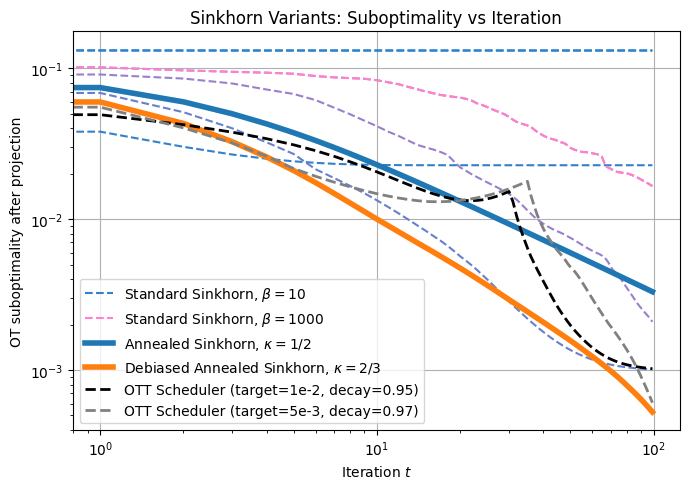

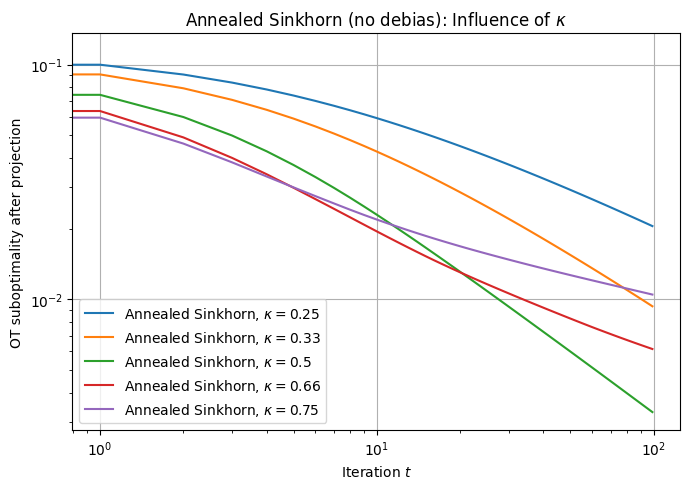

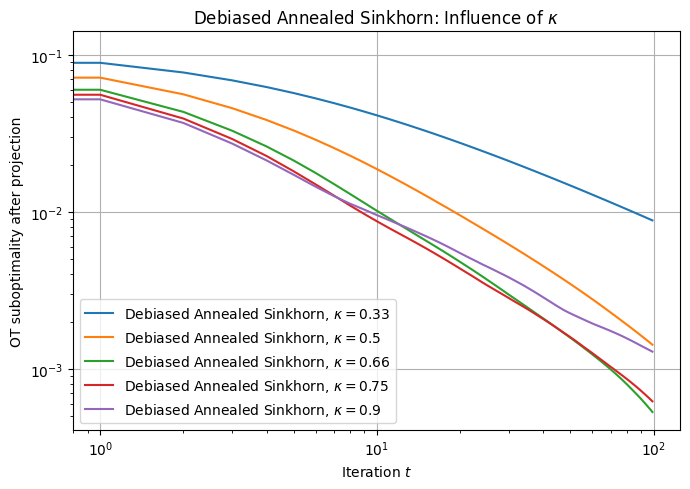

In [17]:
# Run Sinkhorn experiments
niter = 100
beta0 = 10.0

# Annealed Sinkhorn (without debiasing) - kappa = 1/2
_, err1 = sinkhorn_track(p, q, c, niter=niter, OT_cost=OT_cost, kappa=1/2, beta0=beta0, debiased=False)

# Debiased Annealed Sinkhorn - kappa = 2/3
_, err2 = sinkhorn_track(p, q, c, niter=niter, OT_cost=OT_cost, kappa=2/3, beta0=beta0, debiased=True)

# Classical Sinkhorn runs with constant beta values (log-scaled)

beta0s = jnp.array([10.0, 30.0, 100.0, 300.0, 1000.0])  # Only 5 key values

err_tab = jnp.zeros((niter, len(beta0s)))

for k, beta in enumerate(beta0s):
    _, err = sinkhorn_track(p, q, c, niter=niter, OT_cost=OT_cost, kappa=0.0, beta0=beta, debiased=True)
    err_tab = err_tab.at[:, k].set(err)

# Annealed Sinkhorn (no debias) with various kappas
kappas = [0.25, 0.33, 0.5, 0.66, 0.75]
errs_kappa = []

for kappa in kappas:
    _, err = sinkhorn_track(p, q, c, niter=niter, OT_cost=OT_cost, kappa=kappa, beta0=beta0, debiased=False)
    errs_kappa.append(err)

# Debiased Annealed Sinkhorn for various kappas
kappas_debiased = [0.33, 0.5, 0.66, 0.75, 0.9]
errs_kappa_debiased = []

for kappa in kappas_debiased:
    _, err = sinkhorn_track(p, q, c, niter=niter, OT_cost=OT_cost, kappa=kappa, beta0=beta0, debiased=True)
    errs_kappa_debiased.append(err)

# Scheduler-based runs
sched1 = epsilon_scheduler.Epsilon(target=1e-2, init=5.0, decay=0.95)
sched2 = epsilon_scheduler.Epsilon(target=5e-3, init=3.0, decay=0.97)

_, err_sched1 = sinkhorn_track_scheduler(p, q, c, scheduler=sched1, OT_cost=OT_cost, niter=niter)
_, err_sched2 = sinkhorn_track_scheduler(p, q, c, scheduler=sched2, OT_cost=OT_cost, niter=niter)


# Plot 1: Classic Sinkhorn vs Annealed & Debiased (+ schedulers)
plt.figure(figsize=(7, 5))
for k in range(len(beta0s)):
    plt.loglog(err_tab[:, k], '--', color=[k/len(beta0s), 0.5, 0.8])
plt.loglog(err_tab[:, 0], '--', color=[1/len(beta0s), 0.5, 0.8], label=r'Standard Sinkhorn, $\beta=10$')
plt.loglog(err_tab[:, -1], '--', color=[1, 0.5, 0.8], label=r'Standard Sinkhorn, $\beta=1000$')

plt.loglog(err1, label=r'Annealed Sinkhorn, $\kappa=1/2$', linewidth=4)
plt.loglog(err2, label=r'Debiased Annealed Sinkhorn, $\kappa=2/3$', linewidth=4)

# Add OTT schedulers
plt.loglog(err_sched1, label="OTT Scheduler (target=1e-2, decay=0.95)", linestyle="--", linewidth=2, color="black")
plt.loglog(err_sched2, label="OTT Scheduler (target=5e-3, decay=0.97)", linestyle="--", linewidth=2, color="gray")

plt.xlabel(r'Iteration $t$')
plt.ylabel('OT suboptimality after projection')
plt.title("Sinkhorn Variants: Suboptimality vs Iteration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Annealed Sinkhorn (no debias) for various kappas
plt.figure(figsize=(7, 5))
for kappa, err in zip(kappas, errs_kappa):
    plt.loglog(err, label=fr'Annealed Sinkhorn, $\kappa={kappa}$')
plt.xlabel(r'Iteration $t$')
plt.ylabel('OT suboptimality after projection')
plt.title("Annealed Sinkhorn (no debias): Influence of $\kappa$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Debiased Annealed Sinkhorn for various kappas
plt.figure(figsize=(7, 5))
for kappa, err in zip(kappas_debiased, errs_kappa_debiased):
    plt.loglog(err, label=fr'Debiased Annealed Sinkhorn, $\kappa={kappa}$')
plt.xlabel(r'Iteration $t$')
plt.ylabel('OT suboptimality after projection')
plt.title("Debiased Annealed Sinkhorn: Influence of $\kappa$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Suboptimality vs Iteration: Comparing Sinkhorn Variants

#### Graph 1 — Classic vs Annealed vs Debiased

This plot compares the suboptimality of:
- Classical Sinkhorn solvers with fixed $\beta$ (dashed lines),
- Annealed Sinkhorn with $\kappa = 1/2$ (blue),
- Debiased Annealed Sinkhorn with $\kappa = 2/3$ (orange),
- OTT Sinkhorn solvers using exponential $\varepsilon$-schedulers (black and gray dashed lines).

We observe that:
- **Annealed Sinkhorn with $\kappa = 1/2$** consistently outperforms most classical Sinkhorn variants in early-to-mid iterations.
- Only **classical Sinkhorn with very large $\beta$** (i.e., very small $\varepsilon$) eventually outperforms it — but those methods stagnate longer 
- **Debiased Annealed Sinkhorn**, theoretically optimal for $\kappa = 2/3$, achieves nearly the **best convergence rate** and the lowest suboptimality overall.

####  OTT Schedulers

We also include two **OTT-JAX scheduler-based** runs, using exponential decay strategies. These curves are competitive with the best annealing strategies, and show **rapid convergence when well tuned**.

However, an important limitation is that OTT schedulers are defined to reach a **fixed `target` $\varepsilon$**, meaning the algorithm ultimately behaves like a fixed-$\varepsilon$ Sinkhorn once $\varepsilon_t$ stabilizes.

As a consequence, **OTT scheduler methods do not converge to the true OT plan** as $t \to \infty$, unlike Annealed Sinkhorn which continues decreasing $\varepsilon_t$.

Despite this, the OTT scheduler provides a convenient, tunable and stable way to approach low-regularization regimes without requiring custom implementation.


#### Graphs 2 & 3 — Influence of $\kappa$

- In both annealed settings (with and without debiasing), we compare multiple values of $\kappa$.
- The plots confirm theoretical insights:
  - **$\kappa = 1/2$** is optimal for classical Annealed Sinkhorn.
  - **$\kappa = 2/3$** is optimal for debisaed Annealed Sinkhorn

These results validate the importance of choosing the appropriate annealing schedule and demonstrate the power of debiasing in reducing OT suboptimality.

 **Note:**
 - The transport costs in this section are **not normalized**.
 - The first experiment tries to **replicate the results of Lénaïc Chizat** and add OTT Schedulers-based runs.


